Este notebook y todos los que tienen un nombre similar a este son prácticamente iguales. Su contenido también es muy similar al del notebook "IBM_MSE", la principal diferencia es que en esta serie de notebooks, en lugar de utilizar una secuencia temporal diaria, utilizo una secuencia temporal en la que los días van de 2 en 2, de 3 en 3...

El objetivo es tener diferentes modelos que puedan hacer predicciones en este orden (el de "IBM_MSE" hará las predicciones para hoy, el de 2 días las hará para mañana, el de 3 para pasado mañana, etc.)

Veremos como según vamos aumentando el tamaño de los saltos en el tiempo, los modelos empiezan a ser cada vez más imprecisos. El objetivo no es conseguir predicciones exactas, ya que creo que se trata de una tarea imposible, sino que al final lo que busco con estos modelos es tener un conjunto de predicciones que me puedan, en cierto modo y de forma conjunta, "asegurar" que los valores van a seguir una cierta tendencia.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from joblib import load

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from tensorflow import set_random_seed
set_random_seed(12)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaco

# Preprocessing

In [2]:
data = pd.read_csv('./datasets/IBM_daily.csv').sort_values(by='date')

In [3]:
data

,date,1. open,2. high,3. low,4. close,5. volume
5217,1999-11-01,98.50,98.8100,96.37,96.75,9551800.0
5216,1999-11-02,96.75,96.8100,93.69,94.81,11105400.0
5215,1999-11-03,95.87,95.9400,93.50,94.37,10369100.0
5214,1999-11-04,94.44,94.4400,90.00,91.56,16697600.0
5213,1999-11-05,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...,...
4,2020-07-22,125.90,129.4700,125.80,128.67,8195366.0
3,2020-07-23,129.10,129.3700,127.15,127.33,4220136.0
2,2020-07-24,126.48,127.6459,125.50,125.79,3531076.0
1,2020-07-27,124.86,126.3200,124.71,126.21,3733547.0


In [4]:
data = data.drop(columns='date')
data

,1. open,2. high,3. low,4. close,5. volume
5217,98.50,98.8100,96.37,96.75,9551800.0
5216,96.75,96.8100,93.69,94.81,11105400.0
5215,95.87,95.9400,93.50,94.37,10369100.0
5214,94.44,94.4400,90.00,91.56,16697600.0
5213,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...
4,125.90,129.4700,125.80,128.67,8195366.0
3,129.10,129.3700,127.15,127.33,4220136.0
2,126.48,127.6459,125.50,125.79,3531076.0
1,124.86,126.3200,124.71,126.21,3733547.0


In [5]:
# Sequence for the LSTM network
backlook = 92

# Days to predict
days = 5

# Size of data split for testing
train_size = 0.9

In [6]:
# Train-Test split
split = int(len(data) * train_size)

train = data.to_numpy()[:split]
test = data.to_numpy()[split:]

In [7]:
# Load normalisers
normaliser = load('./normalisers/x_normaliser.joblib')
y_normaliser = load('./normalisers/y_normaliser.joblib')

In [8]:
# Normalise data
train_norm = normaliser.transform(train)
test_norm = normaliser.transform(test)

##### Now I get indexes for chunks from 5 in 5 days

In [9]:
index = []

for i in range(days):
    index.append(np.arange(i,len(train),days))

In [10]:
ordered_index = []

for i in range(len(index[0]) - backlook):
    for e in range(days):
        try: ordered_index.append(index[e][i:i+backlook])
        except: pass

In [11]:
# Normalised train chunks
X_train = np.array([train_norm[ix].copy() for ix in ordered_index])
Y_train = np.array([train_norm[ordered_index[i+days][-1],3].copy() for i in range(len(ordered_index) - days)])
Y_train = np.expand_dims(Y_train, -1)

In [12]:
# Delete those sequences that doesn't have a -th day in the results
X_train = X_train[:Y_train.shape[0]]

##### Same for test

In [13]:
index = []

for i in range(days):
    index.append(np.arange(i,len(test),days))

In [14]:
ordered_index = []

for i in range(len(index[0]) - backlook):
    for e in range(days):
        try: ordered_index.append(index[e][i:i+backlook])
        except: pass

In [15]:
# Normalised train chunks
X_test = np.array([test_norm[ix].copy() for ix in ordered_index])
Y_test = np.array([test_norm[ordered_index[i+days][-1],3].copy() for i in range(len(ordered_index) - days)])
Y_test = np.expand_dims(Y_test, -1)

In [16]:
# Delete those sequences that doesn't have a -th day in the results
X_test = X_test[:Y_test.shape[0]]

# Model selection

##### Model constructor

In [17]:
def build_lstm(x, y, batch_size=512, epochs=24, **params):
    
    # List of parameters
    if 'lstmsize' not in params: params['lstmsize'] = x.shape[1]
    if 'density' not in params: params['density'] = int((params['lstmsize']//1.5)*2)
    if 'activation' not in params: params['activation'] = 'relu'
    if 'twice' not in params: params['twice'] = False
    if 'optimizer' not in params: params['optimizer'] = 'adam'
    if 'shuffle' not in params: params['shuffle'] = False
    
    # Model definition
    model = Sequential()
    
    model.add(LSTM(params['lstmsize'], input_shape=x.shape[1:], return_sequences=params['twice']))
    
    if 'dropout' in params:
        model.add(Dropout(params['dropout']))
    
    if params['twice']:
        model.add(LSTM(params['lstmsize']))
        
        if 'dropout' in params:
            model.add(Dropout(params['dropout']))
            
    model.add(Dense(params['density'], activation=params['activation']))
    
    if 'full_density' in params and params['full_density']:
        density = params['density']//2
        while density >= 12:
            model.add(Dense(density, activation=params['activation']))
            density //= 2
            
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mse', optimizer=params['optimizer'])
    
    if 'callbacks' in params:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'],
                            callbacks=params['callbacks'])
    else:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'])
    
    return [model, callback, params]

##### Evolutive algorith to search for the most optimal model

In [18]:
def set_genes(x, y, population_size, population=[]):
    if population_size-len(population) < 0:
        print('population size must be greater or equal than actual population')
        return
    
    if len(population) > 0:
        if len(population) < 3:
            print('population should be empty or 3 at least')
            return
        
        population[2] = breed_genes(x, y, population[0][2].copy())
        population[1] = breed_genes(x, y, combine=(population[0][2], population[1][2]))
        population = population[:3]
    
    for _ in range(population_size-len(population)):
        subject = breed_genes(x, y)
        population.append(subject)
        
    return population

def breed_genes(x, y, genes={}, combine=None):
    genes['x'] = x
    genes['y'] = y
    
    if type(combine) is list or type(combine) is tuple:
        genes['lstmsize'] = combine[np.random.randint(0,2)]['lstmsize']
        genes['density'] = combine[np.random.randint(0,2)]['density']
        genes['activation'] = combine[np.random.randint(0,2)]['activation']
        genes['twice'] = combine[np.random.randint(0,2)]['twice']
        genes['optimizer'] = combine[np.random.randint(0,2)]['optimizer']
        genes['shuffle'] = combine[np.random.randint(0,2)]['shuffle']
        
        genes['dropout'] = combine[np.random.randint(0,2)].get('dropout')
        if genes['dropout'] is None: del genes['dropout']
        genes['full_density'] = combine[np.random.randint(0,2)].get('full_density')
        if genes['full_density'] is None: del genes['full_density']
            
    else:
        if np.random.randint(0,3) == 1:
            genes['lstmsize'] = int((np.random.randint(x.shape[1],x.shape[1]*2)//2)*2)

        if np.random.randint(0,3) == 1:
            genes['density'] = int((np.random.randint(x.shape[1]//2,x.shape[1]*2.66)//2)*2)

        if np.random.randint(0,3) == 1:
            activation = [
                'relu',
                'sigmoid',
                'softplus',
                'softsign',
                'tanh',
                'selu',
                'elu',
                'exponential'
            ]
            genes['activation'] = activation[np.random.randint(0,8)]

        if np.random.randint(0,3) == 1:
            genes['twice'] = True

        if np.random.randint(0,3) == 1:
            optimizer = [
                'sgd',
                'rmsprop',
                'adam',
                'adadelta',
                'adagrad',
                'adamax',
                'nadam'
            ]
            genes['optimizer'] = optimizer[np.random.randint(0,7)]

        if np.random.randint(0,3) == 1:
            genes['shuffle'] = True

        if np.random.randint(0,3) == 1:
            genes['dropout'] = np.random.randint(1,4)/10

        if np.random.randint(0,3) == 1:
            genes['full_density'] = True
            
    new_model = build_lstm(**genes)
        
    return new_model

In [19]:
def breed_population(x, y, generations, population_size, population=[]):
    
    if generations > 1 and population_size < 3:
        print('population size should be of a minimum of 3 for more than one generation')
        return
    
    for g in range(generations):
        print(f'\nGENERATION {g}\n')
        population = set_genes(x, y, population_size, population)
        population = sorted(population, key=lambda x: x[1].history['val_loss'][-1]+x[1].history['loss'][-1])
        
    return population

In [20]:
best_models = breed_population(X_train, Y_train, generations=20, population_size=10)


GENERATION 0

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 1s 381us/step - loss: 0.0628 - val_loss: 0.0037
Epoch 2/24
3811/3811 [==============================] - 1s 153us/step - loss: 0.0111 - val_loss: 0.0061
Epoch 3/24
3811/3811 [==============================] - 1s 153us/step - loss: 0.0046 - val_loss: 0.0073
Epoch 4/24
3811/3811 [==============================] - 1s 153us/step - loss: 0.0027 - val_loss: 0.0025
Epoch 5/24
3811/3811 [==============================] - 1s 154us/step - loss: 0.0020 - val_loss: 0.0035
Epoch 6/24
3811/3811 [==============================] - 1s 152us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 7/24
3811/3811 [==============================] - 1s 164us/step - loss: 0.0015 - val_loss: 0.0019
Epoch 8/24
3811/3811 [==============================] - 1s 163us/step - loss: 0.0013 - val

3811/3811 [==============================] - 1s 165us/step - loss: 9.3630e-04 - val_loss: 0.0011
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 2s 556us/step - loss: 0.1551 - val_loss: 0.0744
Epoch 2/24
3811/3811 [==============================] - 1s 387us/step - loss: 0.0644 - val_loss: 0.0385
Epoch 3/24
3811/3811 [==============================] - 1s 387us/step - loss: 0.0556 - val_loss: 0.0279
Epoch 4/24
3811/3811 [==============================] - 1s 390us/step - loss: 0.0515 - val_loss: 0.0252
Epoch 5/24
3811/3811 [==============================] - 1s 388us/step - loss: 0.0482 - val_loss: 0.0228
Epoch 6/24
3811/3811 [==============================] - 1s 390us/step - loss: 0.0451 - val_loss: 0.0214
Epoch 7/24
3811/3811 [==============================] - 1s 388us/step - loss: 0.0420 - val_loss: 0.0201
Epoch 8/24
3811/3811 [==============================] - 1s 387us/step - loss: 0.0390 - val_loss: 0.0185
Epoch 9/24
3811/3811 [==

3811/3811 [==============================] - 1s 388us/step - loss: 0.0028 - val_loss: 0.0041
Epoch 10/24
3811/3811 [==============================] - 1s 387us/step - loss: 0.0029 - val_loss: 0.0042
Epoch 11/24
3811/3811 [==============================] - 1s 389us/step - loss: 0.0028 - val_loss: 0.0032
Epoch 12/24
3811/3811 [==============================] - 1s 392us/step - loss: 0.0026 - val_loss: 0.0032
Epoch 13/24
3811/3811 [==============================] - 1s 389us/step - loss: 0.0026 - val_loss: 0.0024
Epoch 14/24
3811/3811 [==============================] - 1s 390us/step - loss: 0.0032 - val_loss: 0.0026
Epoch 15/24
3811/3811 [==============================] - 1s 388us/step - loss: 0.0028 - val_loss: 0.0024
Epoch 16/24
3811/3811 [==============================] - 1s 388us/step - loss: 0.0026 - val_loss: 0.0023
Epoch 17/24
3811/3811 [==============================] - 1s 389us/step - loss: 0.0027 - val_loss: 0.0024
Epoch 18/24
3811/3811 [==============================] - 1s 388us/s

Epoch 14/24
3811/3811 [==============================] - 1s 304us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 15/24
3811/3811 [==============================] - 1s 306us/step - loss: 0.0015 - val_loss: 0.0036
Epoch 16/24
3811/3811 [==============================] - 1s 306us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 17/24
3811/3811 [==============================] - 1s 304us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 18/24
3811/3811 [==============================] - 1s 306us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 19/24
3811/3811 [==============================] - 1s 307us/step - loss: 0.0015 - val_loss: 0.0015
Epoch 20/24
3811/3811 [==============================] - 1s 309us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 21/24
3811/3811 [==============================] - 1s 305us/step - loss: 0.0014 - val_loss: 0.0022
Epoch 22/24
3811/3811 [==============================] - 1s 306us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 23/24
3811/3811 [==============================] 

Epoch 19/24
3811/3811 [==============================] - 2s 495us/step - loss: 0.0593 - val_loss: 0.0293
Epoch 20/24
3811/3811 [==============================] - 2s 493us/step - loss: 0.0588 - val_loss: 0.0284
Epoch 21/24
3811/3811 [==============================] - 2s 495us/step - loss: 0.0582 - val_loss: 0.0279
Epoch 22/24
3811/3811 [==============================] - 2s 495us/step - loss: 0.0578 - val_loss: 0.0275
Epoch 23/24
3811/3811 [==============================] - 2s 494us/step - loss: 0.0574 - val_loss: 0.0271
Epoch 24/24
3811/3811 [==============================] - 2s 497us/step - loss: 0.0567 - val_loss: 0.0268
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 3s 879us/step - loss: 0.2378 - val_loss: 0.2725
Epoch 2/24
3811/3811 [==============================] - 2s 496us/step - loss: 0.1581 - val_loss: 0.1694
Epoch 3/24
3811/3811 [==============================] - 2s 494us/step - loss: 0.1078 - val_loss: 0.1045
Epoch 4/24


Epoch 24/24
3811/3811 [==============================] - 2s 491us/step - loss: 0.0027 - val_loss: 0.0025

GENERATION 2

Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 2s 569us/step - loss: 0.0651 - val_loss: 0.0052
Epoch 2/24
3811/3811 [==============================] - 1s 167us/step - loss: 0.0160 - val_loss: 0.0028
Epoch 3/24
3811/3811 [==============================] - 1s 167us/step - loss: 0.0065 - val_loss: 0.0030
Epoch 4/24
3811/3811 [==============================] - 1s 167us/step - loss: 0.0051 - val_loss: 0.0047
Epoch 5/24
3811/3811 [==============================] - 1s 167us/step - loss: 0.0038 - val_loss: 0.0020
Epoch 6/24
3811/3811 [==============================] - 1s 167us/step - loss: 0.0032 - val_loss: 0.0030
Epoch 7/24
3811/3811 [==============================] - 1s 168us/step - loss: 0.0027 - val_loss: 0.0022
Epoch 8/24
3811/3811 [==============================] - 1s 168us/step - loss: 0.0024 - val_loss: 0.0028
E

3811/3811 [==============================] - 2s 502us/step - loss: 0.0074 - val_loss: 0.0046
Epoch 5/24
3811/3811 [==============================] - 2s 500us/step - loss: 0.0048 - val_loss: 0.0036
Epoch 6/24
3811/3811 [==============================] - 2s 500us/step - loss: 0.0038 - val_loss: 0.0029
Epoch 7/24
3811/3811 [==============================] - 2s 503us/step - loss: 0.0033 - val_loss: 0.0026
Epoch 8/24
3811/3811 [==============================] - 2s 501us/step - loss: 0.0031 - val_loss: 0.0028
Epoch 9/24
3811/3811 [==============================] - 2s 502us/step - loss: 0.0031 - val_loss: 0.0023
Epoch 10/24
3811/3811 [==============================] - 2s 499us/step - loss: 0.0028 - val_loss: 0.0023
Epoch 11/24
3811/3811 [==============================] - 2s 500us/step - loss: 0.0027 - val_loss: 0.0023
Epoch 12/24
3811/3811 [==============================] - 2s 504us/step - loss: 0.0028 - val_loss: 0.0024
Epoch 13/24
3811/3811 [==============================] - 2s 501us/step -

Epoch 23/24
3811/3811 [==============================] - 2s 498us/step - loss: 674804902281010822451738705920.0000 - val_loss: 18993929176635253194752.0000
Epoch 24/24
3811/3811 [==============================] - 2s 500us/step - loss: 6303397200973189340850489917440.0000 - val_loss: 18993929176635253194752.0000
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 4s 1ms/step - loss: 0.2547 - val_loss: 0.0173
Epoch 2/24
3811/3811 [==============================] - 2s 501us/step - loss: 0.0320 - val_loss: 0.0032
Epoch 3/24
3811/3811 [==============================] - 2s 500us/step - loss: 0.0170 - val_loss: 0.0035
Epoch 4/24
3811/3811 [==============================] - 2s 500us/step - loss: 0.0067 - val_loss: 0.0037
Epoch 5/24
3811/3811 [==============================] - 2s 499us/step - loss: 0.0053 - val_loss: 0.0071
Epoch 6/24
3811/3811 [==============================] - 2s 502us/step - loss: 0.0068 - val_loss: 0.0157
Epoch 7/24
3811/38

Epoch 10/24
3811/3811 [==============================] - 2s 512us/step - loss: 0.0043 - val_loss: 0.0028
Epoch 11/24
3811/3811 [==============================] - 2s 513us/step - loss: 0.0043 - val_loss: 0.0044
Epoch 12/24
3811/3811 [==============================] - 2s 516us/step - loss: 0.0043 - val_loss: 0.0021
Epoch 13/24
3811/3811 [==============================] - 2s 512us/step - loss: 0.0028 - val_loss: 0.0017
Epoch 14/24
3811/3811 [==============================] - 2s 511us/step - loss: 0.0030 - val_loss: 0.0018
Epoch 15/24
3811/3811 [==============================] - 2s 515us/step - loss: 0.0040 - val_loss: 0.0043
Epoch 16/24
3811/3811 [==============================] - 2s 513us/step - loss: 0.0638 - val_loss: 0.9343
Epoch 17/24
3811/3811 [==============================] - 2s 513us/step - loss: 0.1005 - val_loss: 0.0352
Epoch 18/24
3811/3811 [==============================] - 2s 513us/step - loss: 0.0078 - val_loss: 0.0064
Epoch 19/24
3811/3811 [==============================] 

Epoch 15/24
3811/3811 [==============================] - 2s 512us/step - loss: 0.0133 - val_loss: 0.0034
Epoch 16/24
3811/3811 [==============================] - 2s 515us/step - loss: 0.0074 - val_loss: 0.0051
Epoch 17/24
3811/3811 [==============================] - 2s 514us/step - loss: 0.0089 - val_loss: 0.0053
Epoch 18/24
3811/3811 [==============================] - 2s 516us/step - loss: 0.0102 - val_loss: 0.0058
Epoch 19/24
3811/3811 [==============================] - 2s 518us/step - loss: 0.0071 - val_loss: 0.0031
Epoch 20/24
3811/3811 [==============================] - 2s 522us/step - loss: 0.0057 - val_loss: 0.0036
Epoch 21/24
3811/3811 [==============================] - 2s 523us/step - loss: 0.0086 - val_loss: 0.0072
Epoch 22/24
3811/3811 [==============================] - 2s 531us/step - loss: 0.0111 - val_loss: 0.0029
Epoch 23/24
3811/3811 [==============================] - 2s 530us/step - loss: 0.0060 - val_loss: 0.0040
Epoch 24/24
3811/3811 [==============================] 

Epoch 20/24
3811/3811 [==============================] - 1s 171us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 21/24
3811/3811 [==============================] - 1s 175us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 22/24
3811/3811 [==============================] - 1s 176us/step - loss: 0.0011 - val_loss: 0.0014
Epoch 23/24
3811/3811 [==============================] - 1s 173us/step - loss: 0.0011 - val_loss: 0.0013
Epoch 24/24
3811/3811 [==============================] - 1s 173us/step - loss: 0.0011 - val_loss: 0.0014
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 4s 1ms/step - loss: 0.0941 - val_loss: 0.0132
Epoch 2/24
3811/3811 [==============================] - 1s 170us/step - loss: 0.0217 - val_loss: 0.0106
Epoch 3/24
3811/3811 [==============================] - 1s 171us/step - loss: 0.0080 - val_loss: 0.0093
Epoch 4/24
3811/3811 [==============================] - 1s 171us/step - loss: 0.0051 - val_loss: 0.0021
Epoch 5/24
381

Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 6s 2ms/step - loss: 0.7879 - val_loss: 0.0073
Epoch 2/24
3811/3811 [==============================] - 2s 489us/step - loss: 0.0352 - val_loss: 0.0083
Epoch 3/24
3811/3811 [==============================] - 2s 492us/step - loss: 0.0159 - val_loss: 0.0024
Epoch 4/24
3811/3811 [==============================] - 2s 484us/step - loss: 0.0076 - val_loss: 0.0067
Epoch 5/24
3811/3811 [==============================] - 2s 485us/step - loss: 0.0051 - val_loss: 0.0027
Epoch 6/24
3811/3811 [==============================] - 2s 503us/step - loss: 0.0045 - val_loss: 0.0031
Epoch 7/24
3811/3811 [==============================] - 2s 492us/step - loss: 0.0038 - val_loss: 0.0045
Epoch 8/24
3811/3811 [==============================] - 2s 490us/step - loss: 0.0037 - val_loss: 0.0027
Epoch 9/24
3811/3811 [==============================] - 2s 485us/step - loss: 0.0035 - val_loss: 0.0031
Epoch 10/24
3811/38

3811/3811 [==============================] - 1s 174us/step - loss: 0.0019 - val_loss: 0.0023
Epoch 11/24
3811/3811 [==============================] - 1s 173us/step - loss: 0.0017 - val_loss: 0.0017
Epoch 12/24
3811/3811 [==============================] - 1s 172us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 13/24
3811/3811 [==============================] - 1s 173us/step - loss: 0.0014 - val_loss: 0.0019
Epoch 14/24
3811/3811 [==============================] - 1s 171us/step - loss: 0.0013 - val_loss: 0.0017
Epoch 15/24
3811/3811 [==============================] - 1s 174us/step - loss: 0.0013 - val_loss: 0.0016
Epoch 16/24
3811/3811 [==============================] - 1s 172us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 17/24
3811/3811 [==============================] - 1s 172us/step - loss: 0.0011 - val_loss: 0.0013
Epoch 18/24
3811/3811 [==============================] - 1s 172us/step - loss: 0.0011 - val_loss: 0.0013
Epoch 19/24
3811/3811 [==============================] - 1s 172us/s

3811/3811 [==============================] - 1s 353us/step - loss: 0.0039 - val_loss: 0.0027
Epoch 16/24
3811/3811 [==============================] - 1s 351us/step - loss: 0.0088 - val_loss: 0.0038
Epoch 17/24
3811/3811 [==============================] - 1s 352us/step - loss: 0.0038 - val_loss: 0.0033
Epoch 18/24
3811/3811 [==============================] - 1s 353us/step - loss: 0.0054 - val_loss: 0.0115
Epoch 19/24
3811/3811 [==============================] - 1s 351us/step - loss: 0.0065 - val_loss: 0.0020
Epoch 20/24
3811/3811 [==============================] - 1s 352us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 21/24
3811/3811 [==============================] - 1s 355us/step - loss: 0.0090 - val_loss: 0.0019
Epoch 22/24
3811/3811 [==============================] - 1s 352us/step - loss: 0.0030 - val_loss: 0.0020
Epoch 23/24
3811/3811 [==============================] - 1s 356us/step - loss: 0.0053 - val_loss: 0.0018
Epoch 24/24
3811/3811 [==============================] - 1s 351us/s

Epoch 3/24
3811/3811 [==============================] - ETA: 0s - loss: 0.007 - 1s 177us/step - loss: 0.0075 - val_loss: 0.0016
Epoch 4/24
3811/3811 [==============================] - 1s 177us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 5/24
3811/3811 [==============================] - 1s 176us/step - loss: 0.0056 - val_loss: 0.0159
Epoch 6/24
3811/3811 [==============================] - 1s 176us/step - loss: 0.0086 - val_loss: 0.0015
Epoch 7/24
3811/3811 [==============================] - 1s 177us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 8/24
3811/3811 [==============================] - 1s 180us/step - loss: 0.0012 - val_loss: 0.0016
Epoch 9/24
3811/3811 [==============================] - 1s 178us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 10/24
3811/3811 [==============================] - 1s 182us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 11/24
3811/3811 [==============================] - 1s 181us/step - loss: 0.0011 - val_loss: 0.0020
Epoch 12/24
3811/3811 [===============

Epoch 8/24
3811/3811 [==============================] - 2s 518us/step - loss: 0.0048 - val_loss: 0.0211
Epoch 9/24
3811/3811 [==============================] - 2s 516us/step - loss: 0.0090 - val_loss: 0.0025
Epoch 10/24
3811/3811 [==============================] - 2s 512us/step - loss: 0.0076 - val_loss: 0.0132
Epoch 11/24
3811/3811 [==============================] - 2s 512us/step - loss: 0.0111 - val_loss: 0.0023
Epoch 12/24
3811/3811 [==============================] - 2s 512us/step - loss: 0.0049 - val_loss: 0.0060
Epoch 13/24
3811/3811 [==============================] - 2s 511us/step - loss: 0.0075 - val_loss: 0.0045
Epoch 14/24
3811/3811 [==============================] - 2s 511us/step - loss: 0.0076 - val_loss: 0.0021
Epoch 15/24
3811/3811 [==============================] - 2s 511us/step - loss: 0.0044 - val_loss: 0.0028
Epoch 16/24
3811/3811 [==============================] - 2s 511us/step - loss: 0.0084 - val_loss: 0.0031
Epoch 17/24
3811/3811 [==============================] - 

3811/3811 [==============================] - 1s 370us/step - loss: 0.0052 - val_loss: 0.0034
Epoch 14/24
3811/3811 [==============================] - 1s 371us/step - loss: 0.0085 - val_loss: 0.0097
Epoch 15/24
3811/3811 [==============================] - 1s 370us/step - loss: 0.0047 - val_loss: 0.0022
Epoch 16/24
3811/3811 [==============================] - 1s 374us/step - loss: 0.0065 - val_loss: 0.0073
Epoch 17/24
3811/3811 [==============================] - 1s 371us/step - loss: 0.0052 - val_loss: 0.0036
Epoch 18/24
3811/3811 [==============================] - 1s 372us/step - loss: 0.0067 - val_loss: 0.0067
Epoch 19/24
3811/3811 [==============================] - 1s 369us/step - loss: 0.0047 - val_loss: 0.0021
Epoch 20/24
3811/3811 [==============================] - 1s 369us/step - loss: 0.0068 - val_loss: 0.0041
Epoch 21/24
3811/3811 [==============================] - 1s 370us/step - loss: 0.0037 - val_loss: 0.0025
Epoch 22/24
3811/3811 [==============================] - 1s 369us/s

Epoch 18/24
3811/3811 [==============================] - 1s 355us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 19/24
3811/3811 [==============================] - 1s 357us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 20/24
3811/3811 [==============================] - 1s 356us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 21/24
3811/3811 [==============================] - 1s 352us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 22/24
3811/3811 [==============================] - 1s 352us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 23/24
3811/3811 [==============================] - 1s 353us/step - loss: 0.0014 - val_loss: 0.0015
Epoch 24/24
3811/3811 [==============================] - 1s 353us/step - loss: 0.0014 - val_loss: 0.0015
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 9s 2ms/step - loss: 0.0865 - val_loss: 0.0184
Epoch 2/24
3811/3811 [==============================] - 1s 388us/step - loss: 0.0144 - val_loss: 0.0077
Epoch 3/24
3

3811/3811 [==============================] - 1s 173us/step - loss: 0.0026 - val_loss: 0.0082
Epoch 8/24
3811/3811 [==============================] - 1s 176us/step - loss: 0.0035 - val_loss: 0.0059
Epoch 9/24
3811/3811 [==============================] - 1s 172us/step - loss: 0.0021 - val_loss: 0.0029
Epoch 10/24
3811/3811 [==============================] - 1s 175us/step - loss: 0.0018 - val_loss: 0.0037
Epoch 11/24
3811/3811 [==============================] - 1s 174us/step - loss: 0.0019 - val_loss: 0.0033
Epoch 12/24
3811/3811 [==============================] - 1s 174us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 13/24
3811/3811 [==============================] - 1s 174us/step - loss: 0.0022 - val_loss: 0.0014
Epoch 14/24
3811/3811 [==============================] - 1s 175us/step - loss: 0.0020 - val_loss: 0.0015
Epoch 15/24
3811/3811 [==============================] - 1s 175us/step - loss: 0.0015 - val_loss: 0.0031
Epoch 16/24
3811/3811 [==============================] - 1s 174us/ste

Epoch 16/24
3811/3811 [==============================] - 1s 385us/step - loss: 0.0047 - val_loss: 0.0023
Epoch 17/24
3811/3811 [==============================] - 1s 387us/step - loss: 0.0045 - val_loss: 0.0022
Epoch 18/24
3811/3811 [==============================] - 1s 387us/step - loss: 0.0045 - val_loss: 0.0022
Epoch 19/24
3811/3811 [==============================] - 1s 388us/step - loss: 0.0046 - val_loss: 0.0022
Epoch 20/24
3811/3811 [==============================] - 1s 389us/step - loss: 0.0045 - val_loss: 0.0022
Epoch 21/24
3811/3811 [==============================] - 1s 385us/step - loss: 0.0046 - val_loss: 0.0022
Epoch 22/24
3811/3811 [==============================] - 1s 385us/step - loss: 0.0045 - val_loss: 0.0022
Epoch 23/24
3811/3811 [==============================] - 1s 386us/step - loss: 0.0046 - val_loss: 0.0023
Epoch 24/24
3811/3811 [==============================] - 1s 385us/step - loss: 0.0044 - val_loss: 0.0022
Train on 3811 samples, validate on 424 samples
Epoch 1/

Epoch 21/24
3811/3811 [==============================] - 1s 365us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 22/24
3811/3811 [==============================] - 1s 365us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 23/24
3811/3811 [==============================] - 1s 362us/step - loss: 0.0014 - val_loss: 0.0015
Epoch 24/24
3811/3811 [==============================] - 1s 363us/step - loss: 0.0013 - val_loss: 0.0013
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 10s 3ms/step - loss: 0.0680 - val_loss: 0.0061
Epoch 2/24
3811/3811 [==============================] - 1s 181us/step - loss: 0.0174 - val_loss: 0.0043
Epoch 3/24
3811/3811 [==============================] - 1s 180us/step - loss: 0.0069 - val_loss: 0.0021
Epoch 4/24
3811/3811 [==============================] - 1s 181us/step - loss: 0.0049 - val_loss: 0.0044
Epoch 5/24
3811/3811 [==============================] - 1s 181us/step - loss: 0.0037 - val_loss: 0.0020
Epoch 6/24
381

3811/3811 [==============================] - 12s 3ms/step - loss: 0.1482 - val_loss: 0.0612
Epoch 2/24
3811/3811 [==============================] - 1s 378us/step - loss: 0.0547 - val_loss: 0.0266
Epoch 3/24
3811/3811 [==============================] - 1s 378us/step - loss: 0.0467 - val_loss: 0.0188
Epoch 4/24
3811/3811 [==============================] - 1s 376us/step - loss: 0.0423 - val_loss: 0.0166
Epoch 5/24
3811/3811 [==============================] - 1s 377us/step - loss: 0.0383 - val_loss: 0.0137
Epoch 6/24
3811/3811 [==============================] - 1s 373us/step - loss: 0.0343 - val_loss: 0.0125
Epoch 7/24
3811/3811 [==============================] - 1s 376us/step - loss: 0.0305 - val_loss: 0.0109
Epoch 8/24
3811/3811 [==============================] - 1s 375us/step - loss: 0.0271 - val_loss: 0.0091
Epoch 9/24
3811/3811 [==============================] - 1s 376us/step - loss: 0.0239 - val_loss: 0.0079
Epoch 10/24
3811/3811 [==============================] - 1s 374us/step - los

Epoch 11/24
3811/3811 [==============================] - 1s 182us/step - loss: 0.0015 - val_loss: 0.0020
Epoch 12/24
3811/3811 [==============================] - 1s 182us/step - loss: 0.0013 - val_loss: 0.0016
Epoch 13/24
3811/3811 [==============================] - 1s 181us/step - loss: 0.0012 - val_loss: 0.0017
Epoch 14/24
3811/3811 [==============================] - 1s 182us/step - loss: 0.0011 - val_loss: 0.0018
Epoch 15/24
3811/3811 [==============================] - 1s 180us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 16/24
3811/3811 [==============================] - 1s 182us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 17/24
3811/3811 [==============================] - 1s 181us/step - loss: 0.0010 - val_loss: 0.0011
Epoch 18/24
3811/3811 [==============================] - 1s 182us/step - loss: 0.0010 - val_loss: 0.0011
Epoch 19/24
3811/3811 [==============================] - 1s 180us/step - loss: 0.0010 - val_loss: 0.0014
Epoch 20/24
3811/3811 [==============================] 

Epoch 16/24
3811/3811 [==============================] - 2s 516us/step - loss: 0.0022 - val_loss: 0.0025
Epoch 17/24
3811/3811 [==============================] - 2s 516us/step - loss: 0.0021 - val_loss: 0.0025
Epoch 18/24
3811/3811 [==============================] - 2s 516us/step - loss: 0.0022 - val_loss: 0.0024
Epoch 19/24
3811/3811 [==============================] - 2s 518us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 20/24
3811/3811 [==============================] - 2s 518us/step - loss: 0.0021 - val_loss: 0.0024
Epoch 21/24
3811/3811 [==============================] - 2s 517us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 22/24
3811/3811 [==============================] - 2s 522us/step - loss: 0.0021 - val_loss: 0.0024
Epoch 23/24
3811/3811 [==============================] - 2s 516us/step - loss: 0.0021 - val_loss: 0.0025
Epoch 24/24
3811/3811 [==============================] - 2s 518us/step - loss: 0.0020 - val_loss: 0.0023
Train on 3811 samples, validate on 424 samples
Epoch 1/

Epoch 21/24
3811/3811 [==============================] - 2s 522us/step - loss: 0.0028 - val_loss: 0.0030
Epoch 22/24
3811/3811 [==============================] - 2s 520us/step - loss: 0.0028 - val_loss: 0.0030
Epoch 23/24
3811/3811 [==============================] - 2s 519us/step - loss: 0.0029 - val_loss: 0.0029
Epoch 24/24
3811/3811 [==============================] - 2s 519us/step - loss: 0.0028 - val_loss: 0.0030
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 14s 4ms/step - loss: 0.5314 - val_loss: 0.0025
Epoch 2/24
3811/3811 [==============================] - 1s 339us/step - loss: 0.0053 - val_loss: 0.0046
Epoch 3/24
3811/3811 [==============================] - 1s 340us/step - loss: 0.0045 - val_loss: 0.0034
Epoch 4/24
3811/3811 [==============================] - 1s 339us/step - loss: 0.0042 - val_loss: 0.0031
Epoch 5/24
3811/3811 [==============================] - 1s 340us/step - loss: 0.0041 - val_loss: 0.0036
Epoch 6/24
381

3811/3811 [==============================] - 14s 4ms/step - loss: 0.0866 - val_loss: 0.0059
Epoch 2/24
3811/3811 [==============================] - 1s 185us/step - loss: 0.0222 - val_loss: 0.0020
Epoch 3/24
3811/3811 [==============================] - 1s 189us/step - loss: 0.0087 - val_loss: 0.0050
Epoch 4/24
3811/3811 [==============================] - 1s 186us/step - loss: 0.0053 - val_loss: 0.0022
Epoch 5/24
3811/3811 [==============================] - 1s 185us/step - loss: 0.0043 - val_loss: 0.0048
Epoch 6/24
3811/3811 [==============================] - 1s 187us/step - loss: 0.0035 - val_loss: 0.0019
Epoch 7/24
3811/3811 [==============================] - 1s 186us/step - loss: 0.0030 - val_loss: 0.0027
Epoch 8/24
3811/3811 [==============================] - 1s 185us/step - loss: 0.0027 - val_loss: 0.0023
Epoch 9/24
3811/3811 [==============================] - 1s 185us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 10/24
3811/3811 [==============================] - 1s 184us/step - los

3811/3811 [==============================] - 2s 549us/step - loss: 0.0062 - val_loss: 0.0034
Epoch 11/24
3811/3811 [==============================] - 2s 546us/step - loss: 0.0077 - val_loss: 0.0074
Epoch 12/24
3811/3811 [==============================] - 2s 549us/step - loss: 0.0145 - val_loss: 0.0083
Epoch 13/24
3811/3811 [==============================] - 2s 549us/step - loss: 0.0101 - val_loss: 0.0027
Epoch 14/24
3811/3811 [==============================] - 2s 547us/step - loss: 0.0041 - val_loss: 0.0028
Epoch 15/24
3811/3811 [==============================] - 2s 547us/step - loss: 0.0031 - val_loss: 0.0024
Epoch 16/24
3811/3811 [==============================] - 2s 546us/step - loss: 0.0039 - val_loss: 0.0102
Epoch 17/24
3811/3811 [==============================] - 2s 548us/step - loss: 0.0148 - val_loss: 0.0149
Epoch 18/24
3811/3811 [==============================] - 2s 549us/step - loss: 0.0110 - val_loss: 0.0026
Epoch 19/24
3811/3811 [==============================] - 2s 549us/s

3811/3811 [==============================] - 2s 514us/step - loss: 0.0072 - val_loss: 0.0040
Epoch 20/24
3811/3811 [==============================] - 2s 517us/step - loss: 0.0116 - val_loss: 0.0138
Epoch 21/24
3811/3811 [==============================] - 2s 514us/step - loss: 0.0053 - val_loss: 0.0110
Epoch 22/24
3811/3811 [==============================] - 2s 516us/step - loss: 0.0083 - val_loss: 0.0055
Epoch 23/24
3811/3811 [==============================] - 2s 516us/step - loss: 0.0080 - val_loss: 0.0302
Epoch 24/24
3811/3811 [==============================] - 2s 515us/step - loss: 0.0060 - val_loss: 0.0125
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 19s 5ms/step - loss: 0.2572 - val_loss: 0.0037
Epoch 2/24
3811/3811 [==============================] - 2s 514us/step - loss: 0.0076 - val_loss: 0.0079
Epoch 3/24
3811/3811 [==============================] - 2s 515us/step - loss: 0.0104 - val_loss: 0.0067
Epoch 4/24
3811/3811 [==

3811/3811 [==============================] - 1s 347us/step - loss: 0.0050 - val_loss: 0.0030

GENERATION 13

Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 20s 5ms/step - loss: 0.0443 - val_loss: 0.0132
Epoch 2/24
3811/3811 [==============================] - 2s 507us/step - loss: 0.0090 - val_loss: 0.0036
Epoch 3/24
3811/3811 [==============================] - 2s 502us/step - loss: 0.0042 - val_loss: 0.0027
Epoch 4/24
3811/3811 [==============================] - 2s 506us/step - loss: 0.0035 - val_loss: 0.0052
Epoch 5/24
3811/3811 [==============================] - 2s 505us/step - loss: 0.0026 - val_loss: 0.0038
Epoch 6/24
3811/3811 [==============================] - 2s 507us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 7/24
3811/3811 [==============================] - 2s 508us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 8/24
3811/3811 [==============================] - 2s 505us/step - loss: 0.0020 - val_loss: 0.0024
Epoch 9/24
38

3811/3811 [==============================] - 2s 535us/step - loss: 0.0063 - val_loss: 0.0080
Epoch 10/24
3811/3811 [==============================] - 2s 534us/step - loss: 0.0081 - val_loss: 0.0034
Epoch 11/24
3811/3811 [==============================] - 2s 539us/step - loss: 0.0039 - val_loss: 0.0043
Epoch 12/24
3811/3811 [==============================] - 2s 537us/step - loss: 0.0047 - val_loss: 0.0024
Epoch 13/24
3811/3811 [==============================] - 2s 536us/step - loss: 0.0046 - val_loss: 0.0061
Epoch 14/24
3811/3811 [==============================] - 2s 533us/step - loss: 0.0060 - val_loss: 0.0045
Epoch 15/24
3811/3811 [==============================] - 2s 534us/step - loss: 0.0051 - val_loss: 0.0018
Epoch 16/24
3811/3811 [==============================] - 2s 538us/step - loss: 0.0029 - val_loss: 0.0023
Epoch 17/24
3811/3811 [==============================] - 2s 537us/step - loss: 0.0036 - val_loss: 0.0095
Epoch 18/24
3811/3811 [==============================] - 2s 536us/s

Epoch 14/24
3811/3811 [==============================] - 2s 542us/step - loss: 0.0045 - val_loss: 0.0203
Epoch 15/24
3811/3811 [==============================] - 2s 546us/step - loss: 0.0077 - val_loss: 0.0098
Epoch 16/24
3811/3811 [==============================] - 2s 545us/step - loss: 0.0083 - val_loss: 0.0312
Epoch 17/24
3811/3811 [==============================] - 2s 541us/step - loss: 0.0139 - val_loss: 0.0049
Epoch 18/24
3811/3811 [==============================] - 2s 546us/step - loss: 0.0025 - val_loss: 0.0209
Epoch 19/24
3811/3811 [==============================] - 2s 545us/step - loss: 0.0091 - val_loss: 0.0215
Epoch 20/24
3811/3811 [==============================] - 2s 546us/step - loss: 0.0061 - val_loss: 0.0033
Epoch 21/24
3811/3811 [==============================] - 2s 545us/step - loss: 0.0019 - val_loss: 0.0028
Epoch 22/24
3811/3811 [==============================] - 2s 541us/step - loss: 0.0174 - val_loss: 0.0018
Epoch 23/24
3811/3811 [==============================] 

3811/3811 [==============================] - 2s 560us/step - loss: 810851.5662 - val_loss: 97501.2812
Epoch 3/24
3811/3811 [==============================] - 2s 562us/step - loss: 789510.2406 - val_loss: 96912.6016
Epoch 4/24
3811/3811 [==============================] - 2s 563us/step - loss: 827596.7754 - val_loss: 95828.7734
Epoch 5/24
3811/3811 [==============================] - 2s 563us/step - loss: 928128.1397 - val_loss: 93544.1328
Epoch 6/24
3811/3811 [==============================] - 2s 562us/step - loss: 808804.7320 - val_loss: 91515.7891
Epoch 7/24
3811/3811 [==============================] - 2s 564us/step - loss: 815680.2686 - val_loss: 88425.5156
Epoch 8/24
3811/3811 [==============================] - 2s 564us/step - loss: 871645.9502 - val_loss: 82787.8125
Epoch 9/24
3811/3811 [==============================] - 2s 561us/step - loss: 809242.2425 - val_loss: 77340.8594
Epoch 10/24
3811/3811 [==============================] - 2s 564us/step - loss: 736419.5954 - val_loss: 7213

3811/3811 [==============================] - 1s 203us/step - loss: 0.0059 - val_loss: 0.0041
Epoch 11/24
3811/3811 [==============================] - 1s 202us/step - loss: 0.0063 - val_loss: 0.0083
Epoch 12/24
3811/3811 [==============================] - 1s 196us/step - loss: 0.0050 - val_loss: 0.0056
Epoch 13/24
3811/3811 [==============================] - 1s 197us/step - loss: 0.0051 - val_loss: 0.0058
Epoch 14/24
3811/3811 [==============================] - 1s 197us/step - loss: 0.0051 - val_loss: 0.0034
Epoch 15/24
3811/3811 [==============================] - 1s 194us/step - loss: 0.0041 - val_loss: 0.0033
Epoch 16/24
3811/3811 [==============================] - 1s 195us/step - loss: 0.0051 - val_loss: 0.0051
Epoch 17/24
3811/3811 [==============================] - 1s 195us/step - loss: 0.0037 - val_loss: 0.0073
Epoch 18/24
3811/3811 [==============================] - 1s 197us/step - loss: 0.0046 - val_loss: 0.0030
Epoch 19/24
3811/3811 [==============================] - 1s 196us/s

3811/3811 [==============================] - 1s 392us/step - loss: 0.0077 - val_loss: 0.0050
Epoch 16/24
3811/3811 [==============================] - 1s 392us/step - loss: 0.0047 - val_loss: 0.0036
Epoch 17/24
3811/3811 [==============================] - 1s 392us/step - loss: 0.0054 - val_loss: 0.0047
Epoch 18/24
3811/3811 [==============================] - 1s 393us/step - loss: 0.0061 - val_loss: 0.0053
Epoch 19/24
3811/3811 [==============================] - 1s 390us/step - loss: 0.0063 - val_loss: 0.0087
Epoch 20/24
3811/3811 [==============================] - 1s 392us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 21/24
3811/3811 [==============================] - 1s 393us/step - loss: 0.0057 - val_loss: 0.0065
Epoch 22/24
3811/3811 [==============================] - 2s 395us/step - loss: 0.0063 - val_loss: 0.0068
Epoch 23/24
3811/3811 [==============================] - 2s 394us/step - loss: 0.0064 - val_loss: 0.0085
Epoch 24/24
3811/3811 [==============================] - 1s 391us/s

Epoch 24/24
3811/3811 [==============================] - 1s 210us/step - loss: 0.0040 - val_loss: 0.0033
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 30s 8ms/step - loss: 0.1345 - val_loss: 0.0530
Epoch 2/24
3811/3811 [==============================] - 2s 422us/step - loss: 0.0487 - val_loss: 0.0227
Epoch 3/24
3811/3811 [==============================] - 2s 422us/step - loss: 0.0410 - val_loss: 0.0160
Epoch 4/24
3811/3811 [==============================] - 2s 420us/step - loss: 0.0369 - val_loss: 0.0144
Epoch 5/24
3811/3811 [==============================] - 2s 420us/step - loss: 0.0333 - val_loss: 0.0124
Epoch 6/24
3811/3811 [==============================] - 2s 420us/step - loss: 0.0306 - val_loss: 0.0109
Epoch 7/24
3811/3811 [==============================] - 2s 423us/step - loss: 0.0276 - val_loss: 0.0094
Epoch 8/24
3811/3811 [==============================] - 2s 421us/step - loss: 0.0249 - val_loss: 0.0089
Epoch 9/24
3811/3

3811/3811 [==============================] - 1s 355us/step - loss: 0.0030 - val_loss: 0.0031
Epoch 9/24
3811/3811 [==============================] - 1s 354us/step - loss: 0.0027 - val_loss: 0.0029
Epoch 10/24
3811/3811 [==============================] - 1s 354us/step - loss: 0.0026 - val_loss: 0.0029
Epoch 11/24
3811/3811 [==============================] - 1s 351us/step - loss: 0.0025 - val_loss: 0.0026
Epoch 12/24
3811/3811 [==============================] - 1s 355us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 13/24
3811/3811 [==============================] - 1s 359us/step - loss: 0.0023 - val_loss: 0.0026
Epoch 14/24
3811/3811 [==============================] - 1s 352us/step - loss: 0.0023 - val_loss: 0.0026
Epoch 15/24
3811/3811 [==============================] - 1s 355us/step - loss: 0.0023 - val_loss: 0.0027
Epoch 16/24
3811/3811 [==============================] - 1s 354us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 17/24
3811/3811 [==============================] - 1s 353us/st

3811/3811 [==============================] - 1s 351us/step - loss: 0.0076 - val_loss: 0.0113
Epoch 14/24
3811/3811 [==============================] - 1s 354us/step - loss: 0.0065 - val_loss: 0.0115
Epoch 15/24
3811/3811 [==============================] - 1s 356us/step - loss: 0.0054 - val_loss: 0.0063
Epoch 16/24
3811/3811 [==============================] - 1s 353us/step - loss: 0.0039 - val_loss: 0.0063
Epoch 17/24
3811/3811 [==============================] - 1s 351us/step - loss: 0.0043 - val_loss: 0.0152
Epoch 18/24
3811/3811 [==============================] - 1s 352us/step - loss: 0.0094 - val_loss: 0.0180
Epoch 19/24
3811/3811 [==============================] - 1s 352us/step - loss: 0.0080 - val_loss: 0.0066
Epoch 20/24
3811/3811 [==============================] - 1s 351us/step - loss: 0.0040 - val_loss: 0.0068
Epoch 21/24
3811/3811 [==============================] - 1s 354us/step - loss: 0.0046 - val_loss: 0.0134
Epoch 22/24
3811/3811 [==============================] - 1s 354us/s

3811/3811 [==============================] - 2s 488us/step - loss: 0.0034 - val_loss: 0.0026
Epoch 19/24
3811/3811 [==============================] - 2s 485us/step - loss: 0.0029 - val_loss: 0.0043
Epoch 20/24
3811/3811 [==============================] - 2s 483us/step - loss: 0.0030 - val_loss: 0.0025
Epoch 21/24
3811/3811 [==============================] - 2s 486us/step - loss: 0.0029 - val_loss: 0.0025
Epoch 22/24
3811/3811 [==============================] - 2s 486us/step - loss: 0.0031 - val_loss: 0.0025
Epoch 23/24
3811/3811 [==============================] - 2s 487us/step - loss: 0.0029 - val_loss: 0.0024
Epoch 24/24
3811/3811 [==============================] - 2s 486us/step - loss: 0.0029 - val_loss: 0.0024

GENERATION 18

Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 34s 9ms/step - loss: 0.0409 - val_loss: 0.0021
Epoch 2/24
3811/3811 [==============================] - 1s 203us/step - loss: 0.0071 - val_loss: 0.0072
Epoch 3

3811/3811 [==============================] - 2s 431us/step - loss: 0.0796 - val_loss: 0.0055
Epoch 3/24
3811/3811 [==============================] - 2s 430us/step - loss: 0.0112 - val_loss: 0.0619
Epoch 4/24
3811/3811 [==============================] - 2s 421us/step - loss: 0.0753 - val_loss: 0.0151
Epoch 5/24
3811/3811 [==============================] - 2s 426us/step - loss: 0.0096 - val_loss: 0.0420
Epoch 6/24
3811/3811 [==============================] - 2s 407us/step - loss: 0.0581 - val_loss: 0.0105
Epoch 7/24
3811/3811 [==============================] - 2s 431us/step - loss: 0.0086 - val_loss: 0.0245
Epoch 8/24
3811/3811 [==============================] - 2s 408us/step - loss: 0.0569 - val_loss: 0.0111
Epoch 9/24
3811/3811 [==============================] - 2s 402us/step - loss: 0.0082 - val_loss: 0.0119
Epoch 10/24
3811/3811 [==============================] - 2s 409us/step - loss: 0.0411 - val_loss: 0.0045
Epoch 11/24
3811/3811 [==============================] - 2s 411us/step - l

Epoch 7/24
3811/3811 [==============================] - 2s 525us/step - loss: 0.0051 - val_loss: 0.0028
Epoch 8/24
3811/3811 [==============================] - 2s 525us/step - loss: 0.0058 - val_loss: 0.0048
Epoch 9/24
3811/3811 [==============================] - 2s 531us/step - loss: 0.0086 - val_loss: 0.0034
Epoch 10/24
3811/3811 [==============================] - 2s 529us/step - loss: 0.0063 - val_loss: 0.0040
Epoch 11/24
3811/3811 [==============================] - 2s 523us/step - loss: 0.0080 - val_loss: 0.0031
Epoch 12/24
3811/3811 [==============================] - 2s 532us/step - loss: 0.0065 - val_loss: 0.0036
Epoch 13/24
3811/3811 [==============================] - 2s 524us/step - loss: 0.0074 - val_loss: 0.0060
Epoch 14/24
3811/3811 [==============================] - 2s 524us/step - loss: 0.0070 - val_loss: 0.0041
Epoch 15/24
3811/3811 [==============================] - 2s 529us/step - loss: 0.0060 - val_loss: 0.0034
Epoch 16/24
3811/3811 [==============================] - 2

3811/3811 [==============================] - 2s 605us/step - loss: 0.0690 - val_loss: 0.0363
Epoch 17/24
3811/3811 [==============================] - 2s 598us/step - loss: 0.0690 - val_loss: 0.0356
Epoch 18/24
3811/3811 [==============================] - 2s 597us/step - loss: 0.0690 - val_loss: 0.0362
Epoch 19/24
3811/3811 [==============================] - 2s 596us/step - loss: 0.0690 - val_loss: 0.0365
Epoch 20/24
3811/3811 [==============================] - 2s 600us/step - loss: 0.0690 - val_loss: 0.0355
Epoch 21/24
3811/3811 [==============================] - 2s 608us/step - loss: 0.0690 - val_loss: 0.0354
Epoch 22/24
3811/3811 [==============================] - 2s 612us/step - loss: 0.0690 - val_loss: 0.0365
Epoch 23/24
3811/3811 [==============================] - 2s 602us/step - loss: 0.0690 - val_loss: 0.0368
Epoch 24/24
3811/3811 [==============================] - 2s 615us/step - loss: 0.0690 - val_loss: 0.0363
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811

In [21]:
best_models[0][1].history['val_loss']

[0.01826084963977337,
 0.012631704099476337,
 0.0014728951500728726,
 0.005815340671688318,
 0.0016750592039898038,
 0.0026102224364876747,
 0.0029148038011044264,
 0.001930467551574111,
 0.0015726684359833598,
 0.0017376557225361466,
 0.001749676768667996,
 0.001490045222453773,
 0.0012396228266879916,
 0.0013619951205328107,
 0.0010872536804527044,
 0.0009584769723005593,
 0.0010840313043445349,
 0.0009911361848935485,
 0.0009053258108906448,
 0.0008892153855413198,
 0.0013362239114940166,
 0.001036342466250062,
 0.0011177314445376396,
 0.0008682223851792514]

In [22]:
print('optimal parameters')
print('_______________________')
for key,val in best_models[0][2].items():
    if key != 'x' and key != 'y': print(f'{key}: {val}')

optimal parameters
_______________________
activation: softsign
shuffle: True
lstmsize: 104
full_density: True
twice: False
optimizer: adam
density: 180


In [23]:
best_models[0][0].summary()

Model: "sequential_138"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_242 (LSTM)              (None, 104)               45760     
_________________________________________________________________
dense_701 (Dense)            (None, 180)               18900     
_________________________________________________________________
dense_702 (Dense)            (None, 90)                16290     
_________________________________________________________________
dense_703 (Dense)            (None, 45)                4095      
_________________________________________________________________
dense_704 (Dense)            (None, 22)                1012      
_________________________________________________________________
dense_705 (Dense)            (None, 1)                 23        
Total params: 86,080
Trainable params: 86,080
Non-trainable params: 0
________________________________________________

In [24]:
ibm_checkpoint = ModelCheckpoint(
    filepath='./checkpoints/IBM.{epoch}-{val_loss}.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [25]:
params = best_models[0][2]
params['x'] = X_train
params['y'] = Y_train
params['epochs'] = 2000
params['callbacks'] = [ibm_checkpoint]

In [26]:
final_model = build_lstm(**params)

Train on 3811 samples, validate on 424 samples
Epoch 1/2000
3811/3811 [==============================] - 44s 12ms/step - loss: 0.0799 - val_loss: 0.0031
Epoch 2/2000
3811/3811 [==============================] - 1s 222us/step - loss: 0.0190 - val_loss: 0.0021
Epoch 3/2000
3811/3811 [==============================] - 1s 211us/step - loss: 0.0077 - val_loss: 0.0021
Epoch 4/2000
3811/3811 [==============================] - 1s 208us/step - loss: 0.0052 - val_loss: 0.0080
Epoch 5/2000
3811/3811 [==============================] - 1s 210us/step - loss: 0.0046 - val_loss: 0.0018
Epoch 6/2000
3811/3811 [==============================] - 1s 209us/step - loss: 0.0036 - val_loss: 0.0033
Epoch 7/2000
3811/3811 [==============================] - 1s 211us/step - loss: 0.0031 - val_loss: 0.0020
Epoch 8/2000
3811/3811 [==============================] - 1s 209us/step - loss: 0.0026 - val_loss: 0.0022
Epoch 9/2000
3811/3811 [==============================] - 1s 209us/step - loss: 0.0023 - val_loss: 0.0029

3811/3811 [==============================] - 1s 210us/step - loss: 6.4192e-04 - val_loss: 6.7604e-04
Epoch 145/2000
3811/3811 [==============================] - 1s 210us/step - loss: 6.3402e-04 - val_loss: 6.6376e-04
Epoch 146/2000
3811/3811 [==============================] - 1s 209us/step - loss: 6.3762e-04 - val_loss: 8.3983e-04
Epoch 147/2000
3811/3811 [==============================] - 1s 210us/step - loss: 6.5847e-04 - val_loss: 6.6540e-04
Epoch 148/2000
3811/3811 [==============================] - 1s 208us/step - loss: 6.3504e-04 - val_loss: 6.5659e-04
Epoch 149/2000
3811/3811 [==============================] - 1s 221us/step - loss: 6.3066e-04 - val_loss: 6.5454e-04
Epoch 150/2000
3811/3811 [==============================] - 1s 211us/step - loss: 6.3130e-04 - val_loss: 6.8392e-04
Epoch 151/2000
3811/3811 [==============================] - 1s 212us/step - loss: 6.5369e-04 - val_loss: 6.5241e-04
Epoch 152/2000
3811/3811 [==============================] - 1s 214us/step - loss: 6.363

Epoch 215/2000
3811/3811 [==============================] - 1s 208us/step - loss: 6.9006e-04 - val_loss: 6.6587e-04
Epoch 216/2000
3811/3811 [==============================] - 1s 206us/step - loss: 6.8551e-04 - val_loss: 9.0072e-04
Epoch 217/2000
3811/3811 [==============================] - 1s 210us/step - loss: 7.2403e-04 - val_loss: 6.4706e-04
Epoch 218/2000
3811/3811 [==============================] - 1s 210us/step - loss: 6.5268e-04 - val_loss: 6.5279e-04
Epoch 219/2000
3811/3811 [==============================] - 1s 212us/step - loss: 6.9072e-04 - val_loss: 6.6249e-04
Epoch 220/2000
3811/3811 [==============================] - 1s 213us/step - loss: 6.5557e-04 - val_loss: 8.7239e-04
Epoch 221/2000
3811/3811 [==============================] - 1s 208us/step - loss: 6.5283e-04 - val_loss: 8.7638e-04
Epoch 222/2000
3811/3811 [==============================] - 1s 208us/step - loss: 6.3971e-04 - val_loss: 7.7209e-04
Epoch 223/2000
3811/3811 [==============================] - 1s 209us/ste

Epoch 356/2000
3811/3811 [==============================] - 1s 210us/step - loss: 6.1202e-04 - val_loss: 6.4530e-04
Epoch 357/2000
3811/3811 [==============================] - 1s 211us/step - loss: 6.0989e-04 - val_loss: 6.6243e-04
Epoch 358/2000
3811/3811 [==============================] - 1s 210us/step - loss: 6.2028e-04 - val_loss: 7.0345e-04
Epoch 359/2000
3811/3811 [==============================] - 1s 208us/step - loss: 6.2427e-04 - val_loss: 6.6010e-04
Epoch 360/2000
3811/3811 [==============================] - 1s 210us/step - loss: 6.1661e-04 - val_loss: 6.3950e-04
Epoch 361/2000
3811/3811 [==============================] - 1s 209us/step - loss: 6.0745e-04 - val_loss: 6.3777e-04
Epoch 362/2000
3811/3811 [==============================] - 1s 210us/step - loss: 5.9511e-04 - val_loss: 7.0507e-04
Epoch 363/2000
3811/3811 [==============================] - 1s 210us/step - loss: 6.2795e-04 - val_loss: 7.8714e-04
Epoch 364/2000
3811/3811 [==============================] - 1s 208us/ste

Epoch 497/2000
3811/3811 [==============================] - 1s 216us/step - loss: 5.9177e-04 - val_loss: 6.3037e-04
Epoch 498/2000
3811/3811 [==============================] - 1s 213us/step - loss: 5.8713e-04 - val_loss: 7.4772e-04
Epoch 499/2000
3811/3811 [==============================] - 1s 209us/step - loss: 6.3959e-04 - val_loss: 6.3919e-04
Epoch 500/2000
3811/3811 [==============================] - 1s 217us/step - loss: 6.1281e-04 - val_loss: 6.5438e-04
Epoch 501/2000
3811/3811 [==============================] - 1s 220us/step - loss: 6.0952e-04 - val_loss: 6.9993e-04
Epoch 502/2000
3811/3811 [==============================] - 1s 220us/step - loss: 6.0219e-04 - val_loss: 6.3637e-04
Epoch 503/2000
3811/3811 [==============================] - 1s 213us/step - loss: 6.0795e-04 - val_loss: 6.3039e-04
Epoch 504/2000
3811/3811 [==============================] - 1s 216us/step - loss: 6.1775e-04 - val_loss: 7.5352e-04
Epoch 505/2000
3811/3811 [==============================] - 1s 213us/ste

Epoch 638/2000
3811/3811 [==============================] - 1s 219us/step - loss: 5.9057e-04 - val_loss: 7.5402e-04
Epoch 639/2000
3811/3811 [==============================] - 1s 209us/step - loss: 6.2112e-04 - val_loss: 7.8222e-04
Epoch 640/2000
3811/3811 [==============================] - 1s 208us/step - loss: 6.6154e-04 - val_loss: 7.2891e-04
Epoch 641/2000
3811/3811 [==============================] - 1s 210us/step - loss: 6.0951e-04 - val_loss: 6.6807e-04
Epoch 642/2000
3811/3811 [==============================] - 1s 208us/step - loss: 5.7096e-04 - val_loss: 8.1189e-04
Epoch 643/2000
3811/3811 [==============================] - 1s 214us/step - loss: 6.4216e-04 - val_loss: 8.6469e-04
Epoch 644/2000
3811/3811 [==============================] - 1s 214us/step - loss: 6.3416e-04 - val_loss: 8.7204e-04
Epoch 645/2000
3811/3811 [==============================] - 1s 211us/step - loss: 6.8402e-04 - val_loss: 6.6016e-04
Epoch 646/2000
3811/3811 [==============================] - 1s 214us/ste

3811/3811 [==============================] - 1s 220us/step - loss: 4.7323e-04 - val_loss: 0.0013
Epoch 780/2000
3811/3811 [==============================] - 1s 212us/step - loss: 4.9381e-04 - val_loss: 0.0012
Epoch 781/2000
3811/3811 [==============================] - 1s 216us/step - loss: 4.8319e-04 - val_loss: 0.0012
Epoch 782/2000
3811/3811 [==============================] - 1s 219us/step - loss: 4.6806e-04 - val_loss: 0.0011
Epoch 783/2000
3811/3811 [==============================] - 1s 217us/step - loss: 4.6875e-04 - val_loss: 0.0013
Epoch 784/2000
3811/3811 [==============================] - 1s 217us/step - loss: 4.7342e-04 - val_loss: 0.0013
Epoch 785/2000
3811/3811 [==============================] - 1s 212us/step - loss: 5.1068e-04 - val_loss: 0.0011
Epoch 786/2000
3811/3811 [==============================] - 1s 219us/step - loss: 4.9548e-04 - val_loss: 0.0012
Epoch 787/2000
3811/3811 [==============================] - 1s 216us/step - loss: 4.9726e-04 - val_loss: 0.0011
Epoch 7

3811/3811 [==============================] - 1s 227us/step - loss: 3.4973e-04 - val_loss: 0.0032
Epoch 926/2000
3811/3811 [==============================] - 1s 223us/step - loss: 3.5484e-04 - val_loss: 0.0033
Epoch 927/2000
3811/3811 [==============================] - 1s 211us/step - loss: 3.5357e-04 - val_loss: 0.0027
Epoch 928/2000
3811/3811 [==============================] - 1s 216us/step - loss: 3.7682e-04 - val_loss: 0.0028
Epoch 929/2000
3811/3811 [==============================] - 1s 211us/step - loss: 3.6423e-04 - val_loss: 0.0031
Epoch 930/2000
3811/3811 [==============================] - 1s 210us/step - loss: 3.5397e-04 - val_loss: 0.0028
Epoch 931/2000
3811/3811 [==============================] - 1s 211us/step - loss: 3.5862e-04 - val_loss: 0.0027
Epoch 932/2000
3811/3811 [==============================] - 1s 216us/step - loss: 3.5240e-04 - val_loss: 0.0029
Epoch 933/2000
3811/3811 [==============================] - 1s 212us/step - loss: 3.4227e-04 - val_loss: 0.0027
Epoch 9

3811/3811 [==============================] - 1s 207us/step - loss: 2.4274e-04 - val_loss: 0.0040
Epoch 1071/2000
3811/3811 [==============================] - 1s 209us/step - loss: 2.6920e-04 - val_loss: 0.0044
Epoch 1072/2000
3811/3811 [==============================] - 1s 207us/step - loss: 2.5866e-04 - val_loss: 0.0047
Epoch 1073/2000
3811/3811 [==============================] - 1s 209us/step - loss: 2.3855e-04 - val_loss: 0.0038
Epoch 1074/2000
3811/3811 [==============================] - 1s 208us/step - loss: 2.2802e-04 - val_loss: 0.0044
Epoch 1075/2000
3811/3811 [==============================] - 1s 210us/step - loss: 2.2190e-04 - val_loss: 0.0047
Epoch 1076/2000
3811/3811 [==============================] - 1s 207us/step - loss: 2.2895e-04 - val_loss: 0.0043
Epoch 1077/2000
3811/3811 [==============================] - 1s 211us/step - loss: 2.3574e-04 - val_loss: 0.0050
Epoch 1078/2000
3811/3811 [==============================] - 1s 209us/step - loss: 2.3652e-04 - val_loss: 0.0046

3811/3811 [==============================] - 1s 206us/step - loss: 1.7433e-04 - val_loss: 0.0049
Epoch 1215/2000
3811/3811 [==============================] - 1s 205us/step - loss: 1.7275e-04 - val_loss: 0.0053
Epoch 1216/2000
3811/3811 [==============================] - 1s 210us/step - loss: 1.6024e-04 - val_loss: 0.0052
Epoch 1217/2000
3811/3811 [==============================] - 1s 214us/step - loss: 1.7352e-04 - val_loss: 0.0053
Epoch 1218/2000
3811/3811 [==============================] - 1s 207us/step - loss: 1.5812e-04 - val_loss: 0.0055
Epoch 1219/2000
3811/3811 [==============================] - 1s 207us/step - loss: 1.5808e-04 - val_loss: 0.0053
Epoch 1220/2000
3811/3811 [==============================] - 1s 207us/step - loss: 1.6110e-04 - val_loss: 0.0053
Epoch 1221/2000
3811/3811 [==============================] - 1s 209us/step - loss: 1.6213e-04 - val_loss: 0.0051
Epoch 1222/2000
3811/3811 [==============================] - 1s 207us/step - loss: 1.8842e-04 - val_loss: 0.0048

3811/3811 [==============================] - 1s 209us/step - loss: 1.3187e-04 - val_loss: 0.0057
Epoch 1359/2000
3811/3811 [==============================] - 1s 208us/step - loss: 1.2409e-04 - val_loss: 0.0056
Epoch 1360/2000
3811/3811 [==============================] - 1s 206us/step - loss: 1.4403e-04 - val_loss: 0.0058
Epoch 1361/2000
3811/3811 [==============================] - 1s 208us/step - loss: 1.4598e-04 - val_loss: 0.0055
Epoch 1362/2000
3811/3811 [==============================] - 1s 205us/step - loss: 1.3260e-04 - val_loss: 0.0053
Epoch 1363/2000
3811/3811 [==============================] - 1s 207us/step - loss: 1.4192e-04 - val_loss: 0.0051
Epoch 1364/2000
3811/3811 [==============================] - 1s 208us/step - loss: 1.3626e-04 - val_loss: 0.0056
Epoch 1365/2000
3811/3811 [==============================] - 1s 208us/step - loss: 1.2403e-04 - val_loss: 0.0054
Epoch 1366/2000
3811/3811 [==============================] - 1s 208us/step - loss: 1.2084e-04 - val_loss: 0.0054

3811/3811 [==============================] - 1s 207us/step - loss: 1.1469e-04 - val_loss: 0.0063
Epoch 1503/2000
3811/3811 [==============================] - 1s 207us/step - loss: 1.1614e-04 - val_loss: 0.0057
Epoch 1504/2000
3811/3811 [==============================] - 1s 206us/step - loss: 1.1750e-04 - val_loss: 0.0060
Epoch 1505/2000
3811/3811 [==============================] - 1s 208us/step - loss: 1.1240e-04 - val_loss: 0.0060
Epoch 1506/2000
3811/3811 [==============================] - 1s 206us/step - loss: 1.0856e-04 - val_loss: 0.0062
Epoch 1507/2000
3811/3811 [==============================] - 1s 207us/step - loss: 1.0041e-04 - val_loss: 0.0061
Epoch 1508/2000
3811/3811 [==============================] - 1s 208us/step - loss: 1.0283e-04 - val_loss: 0.0065
Epoch 1509/2000
3811/3811 [==============================] - 1s 206us/step - loss: 1.0768e-04 - val_loss: 0.0061
Epoch 1510/2000
3811/3811 [==============================] - 1s 208us/step - loss: 1.2240e-04 - val_loss: 0.0060

3811/3811 [==============================] - 1s 206us/step - loss: 8.9785e-05 - val_loss: 0.0062
Epoch 1647/2000
3811/3811 [==============================] - 1s 206us/step - loss: 1.0561e-04 - val_loss: 0.0062
Epoch 1648/2000
3811/3811 [==============================] - 1s 208us/step - loss: 9.4289e-05 - val_loss: 0.0059
Epoch 1649/2000
3811/3811 [==============================] - 1s 208us/step - loss: 9.2700e-05 - val_loss: 0.0063
Epoch 1650/2000
3811/3811 [==============================] - 1s 208us/step - loss: 9.8055e-05 - val_loss: 0.0058
Epoch 1651/2000
3811/3811 [==============================] - 1s 207us/step - loss: 1.0789e-04 - val_loss: 0.0060
Epoch 1652/2000
3811/3811 [==============================] - 1s 208us/step - loss: 1.0328e-04 - val_loss: 0.0063
Epoch 1653/2000
3811/3811 [==============================] - 1s 207us/step - loss: 1.0309e-04 - val_loss: 0.0063
Epoch 1654/2000
3811/3811 [==============================] - 1s 207us/step - loss: 9.1966e-05 - val_loss: 0.0061

3811/3811 [==============================] - 1s 209us/step - loss: 7.1613e-05 - val_loss: 0.0059
Epoch 1791/2000
3811/3811 [==============================] - 1s 208us/step - loss: 7.2895e-05 - val_loss: 0.0062
Epoch 1792/2000
3811/3811 [==============================] - 1s 207us/step - loss: 6.6760e-05 - val_loss: 0.0062
Epoch 1793/2000
3811/3811 [==============================] - 1s 207us/step - loss: 7.0362e-05 - val_loss: 0.0061
Epoch 1794/2000
3811/3811 [==============================] - 1s 209us/step - loss: 7.3921e-05 - val_loss: 0.0062
Epoch 1795/2000
3811/3811 [==============================] - 1s 208us/step - loss: 7.8285e-05 - val_loss: 0.0062
Epoch 1796/2000
3811/3811 [==============================] - 1s 208us/step - loss: 7.7931e-05 - val_loss: 0.0064
Epoch 1797/2000
3811/3811 [==============================] - 1s 209us/step - loss: 7.0014e-05 - val_loss: 0.0064
Epoch 1798/2000
3811/3811 [==============================] - 1s 208us/step - loss: 7.3636e-05 - val_loss: 0.0063

3811/3811 [==============================] - 1s 209us/step - loss: 6.2169e-05 - val_loss: 0.0060
Epoch 1935/2000
3811/3811 [==============================] - 1s 208us/step - loss: 6.3980e-05 - val_loss: 0.0059
Epoch 1936/2000
3811/3811 [==============================] - 1s 206us/step - loss: 6.6461e-05 - val_loss: 0.0060
Epoch 1937/2000
3811/3811 [==============================] - 1s 208us/step - loss: 7.0121e-05 - val_loss: 0.0058
Epoch 1938/2000
3811/3811 [==============================] - 1s 208us/step - loss: 7.5171e-05 - val_loss: 0.0060
Epoch 1939/2000
3811/3811 [==============================] - 1s 207us/step - loss: 7.2695e-05 - val_loss: 0.0057
Epoch 1940/2000
3811/3811 [==============================] - 1s 212us/step - loss: 7.0150e-05 - val_loss: 0.0061
Epoch 1941/2000
3811/3811 [==============================] - 1s 209us/step - loss: 7.4169e-05 - val_loss: 0.0059
Epoch 1942/2000
3811/3811 [==============================] - 1s 208us/step - loss: 6.9774e-05 - val_loss: 0.0058

In [27]:
final_model[2]

{'activation': 'softsign',
 'shuffle': True,
 'lstmsize': 104,
 'full_density': True,
 'twice': False,
 'optimizer': 'adam',
 'density': 180,
 'callbacks': [<keras.callbacks.callbacks.ModelCheckpoint at 0x25663168448>]}

In [28]:
final_model[0].summary()

Model: "sequential_182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_315 (LSTM)              (None, 104)               45760     
_________________________________________________________________
dense_918 (Dense)            (None, 180)               18900     
_________________________________________________________________
dense_919 (Dense)            (None, 90)                16290     
_________________________________________________________________
dense_920 (Dense)            (None, 45)                4095      
_________________________________________________________________
dense_921 (Dense)            (None, 22)                1012      
_________________________________________________________________
dense_922 (Dense)            (None, 1)                 23        
Total params: 86,080
Trainable params: 86,080
Non-trainable params: 0
________________________________________________

In [29]:
final_model[0].load_weights('./checkpoints/IBM_5days/IBM.(best).hdf5')
y_predicted = final_model[0].predict(X_test)

In [30]:
predicted_y_test = y_normaliser.inverse_transform(y_predicted)
true_y_test = y_normaliser.inverse_transform(Y_test)

In [31]:
loss = np.mean((true_y_test - predicted_y_test)**2)
medium_error = np.mean(abs(true_y_test - predicted_y_test))
print(f'MSE is {loss:.2f}\nMedium error is {medium_error:.2f}')

MSE is 29.14
Medium error is 4.44


In [32]:
up_down_test = []
up_down_predicted = []

for y,x in zip(Y_test,X_test):
    if y[0] > x[-1][0]: up_down_test.append(1)
    elif y[0] < x[-1][0]: up_down_test.append(-1)
    else: up_down_test.append(0)
        
for y,x in zip(y_predicted,X_test):
    if y[0] > x[-1][0]: up_down_predicted.append(1)
    elif y[0] < x[-1][0]: up_down_predicted.append(-1)
    else: up_down_predicted.append(0)

In [33]:
print(f'Trend accuracy is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == p)/len(up_down_test))*100:.2f}%')

Trend accuracy is: 56.67%


In [34]:
print(f'Accuracy for upward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == 1 and p == 1)/sum(1 for v in up_down_test if v == 1))*100:.2f}%')
print(f'Accuracy for downward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == -1 and p == -1)/sum(1 for v in up_down_test if v == -1))*100:.2f}%')

Accuracy for upward trend is: 33.33%
Accuracy for downward trend is: 80.00%


##### Predictions over the last 60 days in test

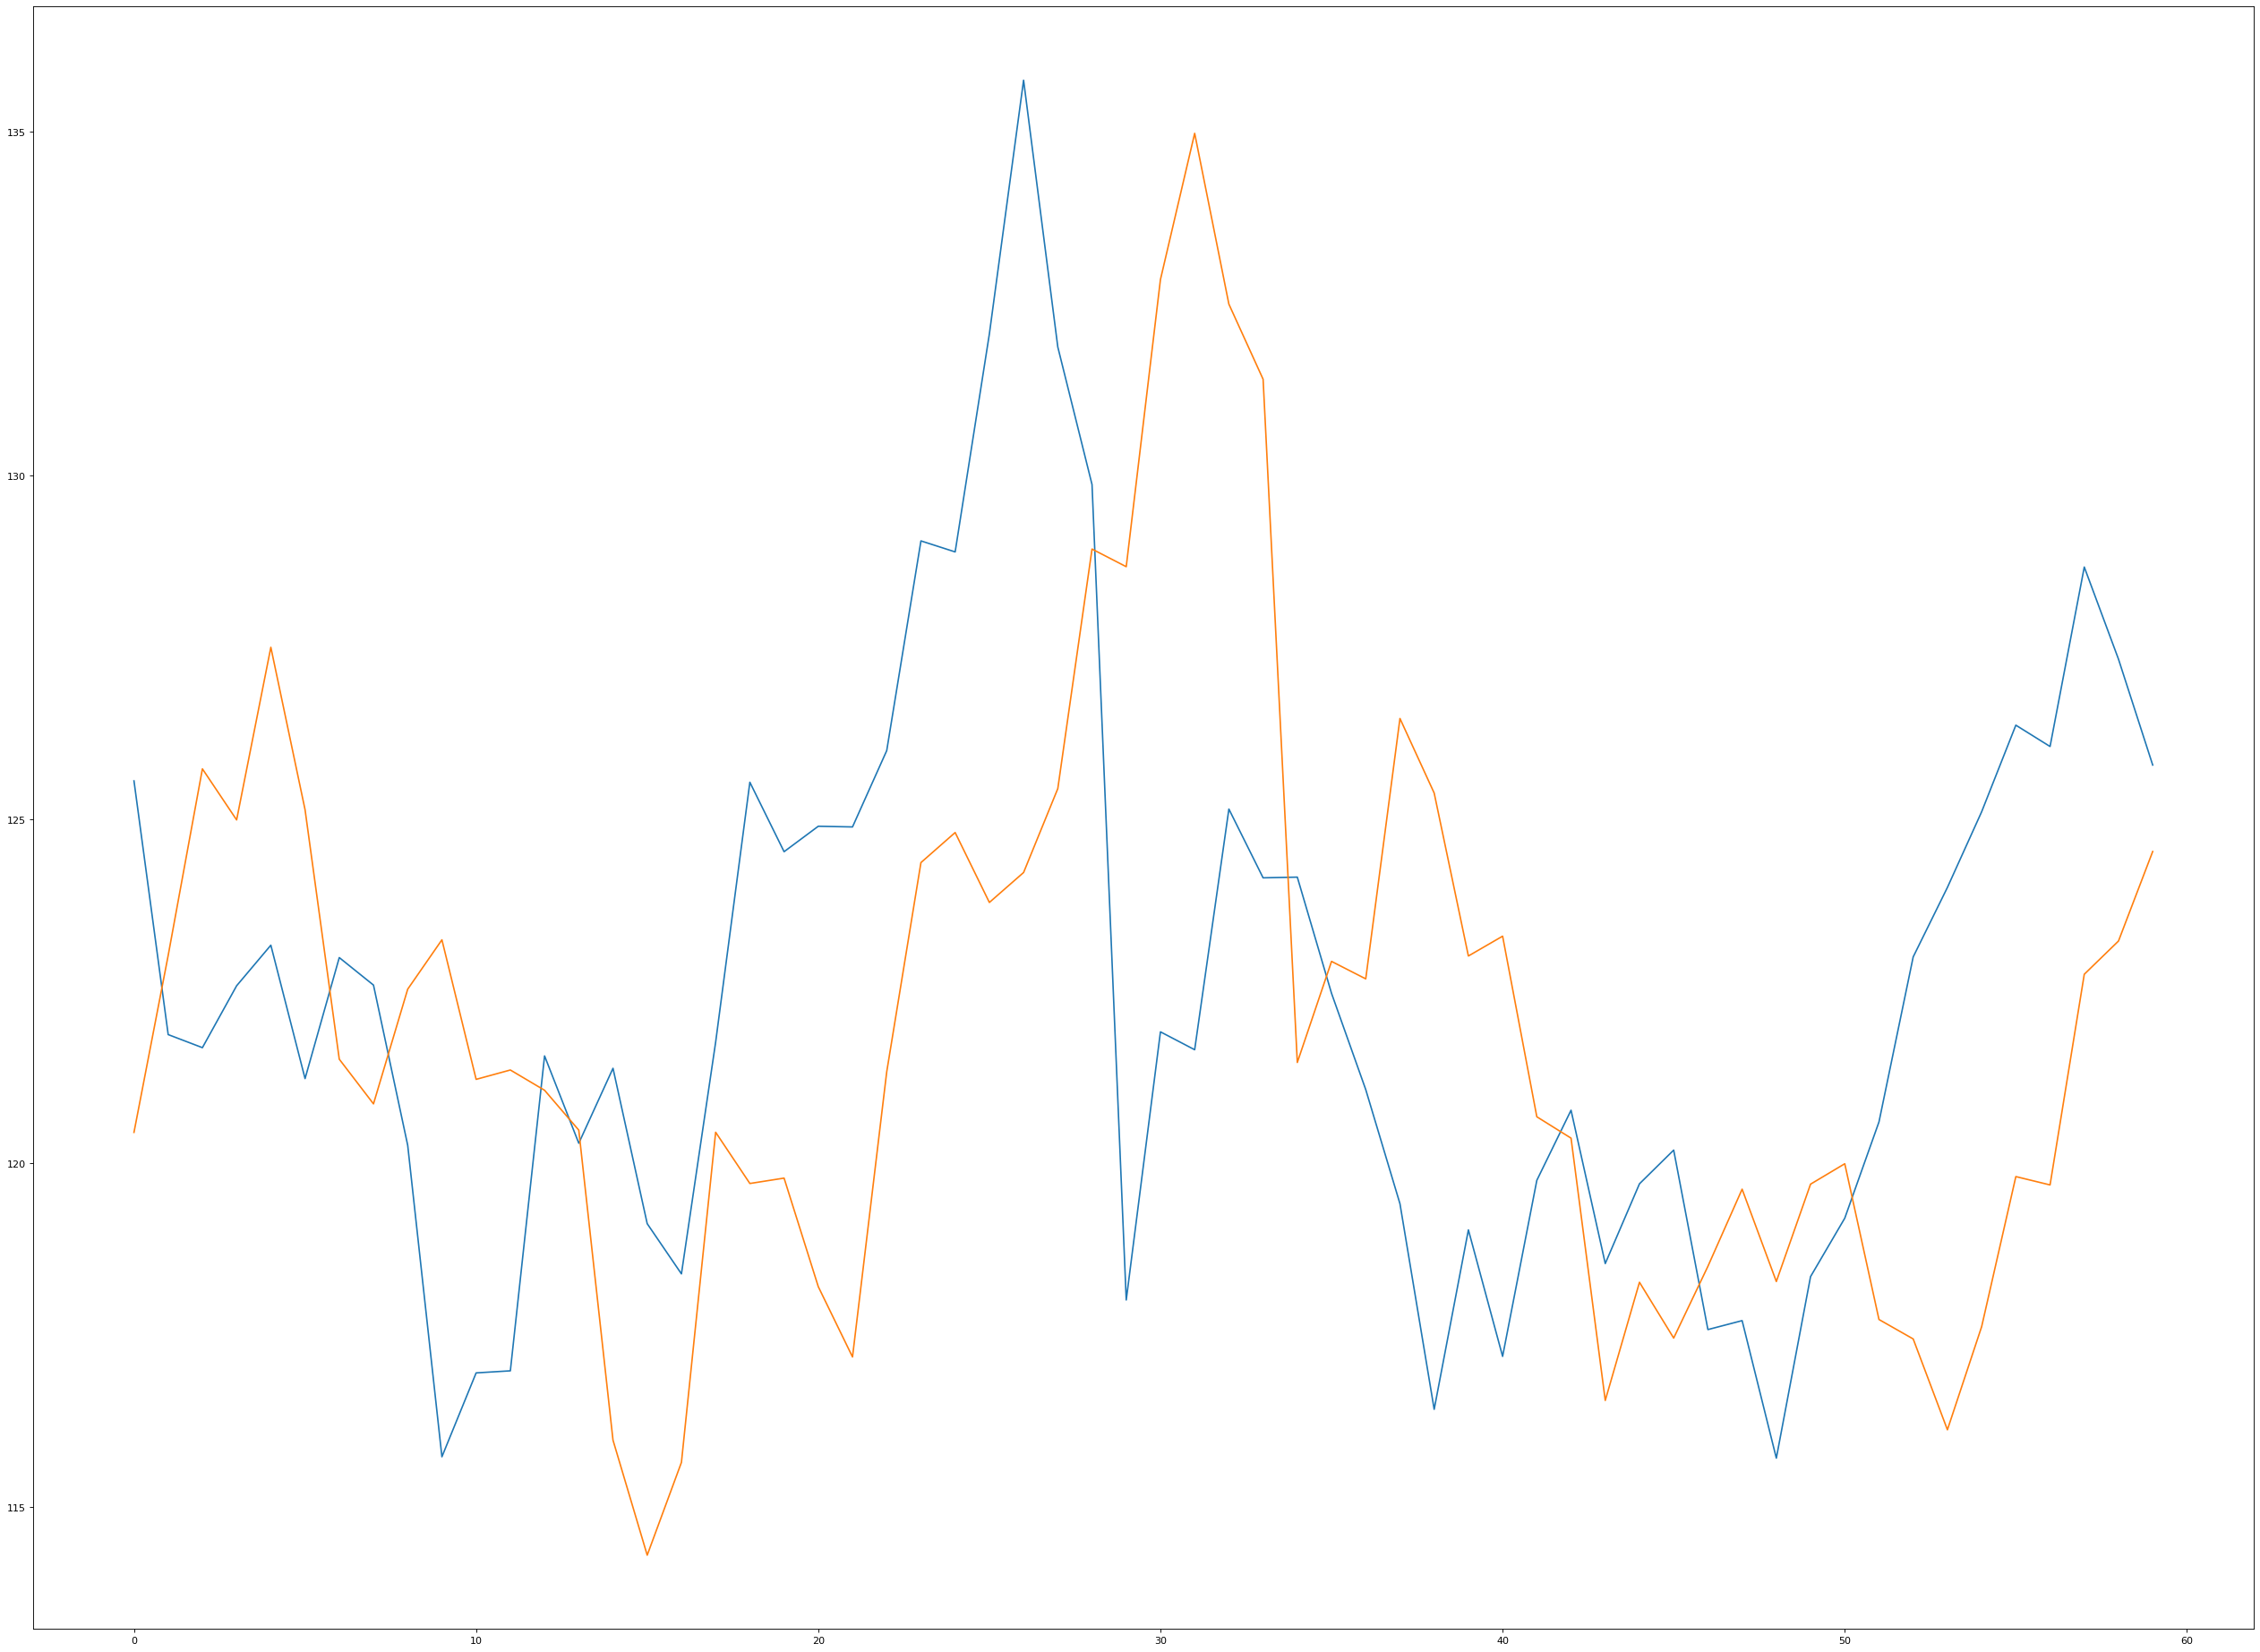

In [35]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(60), true_y_test)
plt.plot(range(60), predicted_y_test)
plt.show()

##### Last 20 days + prediction of last 10 days

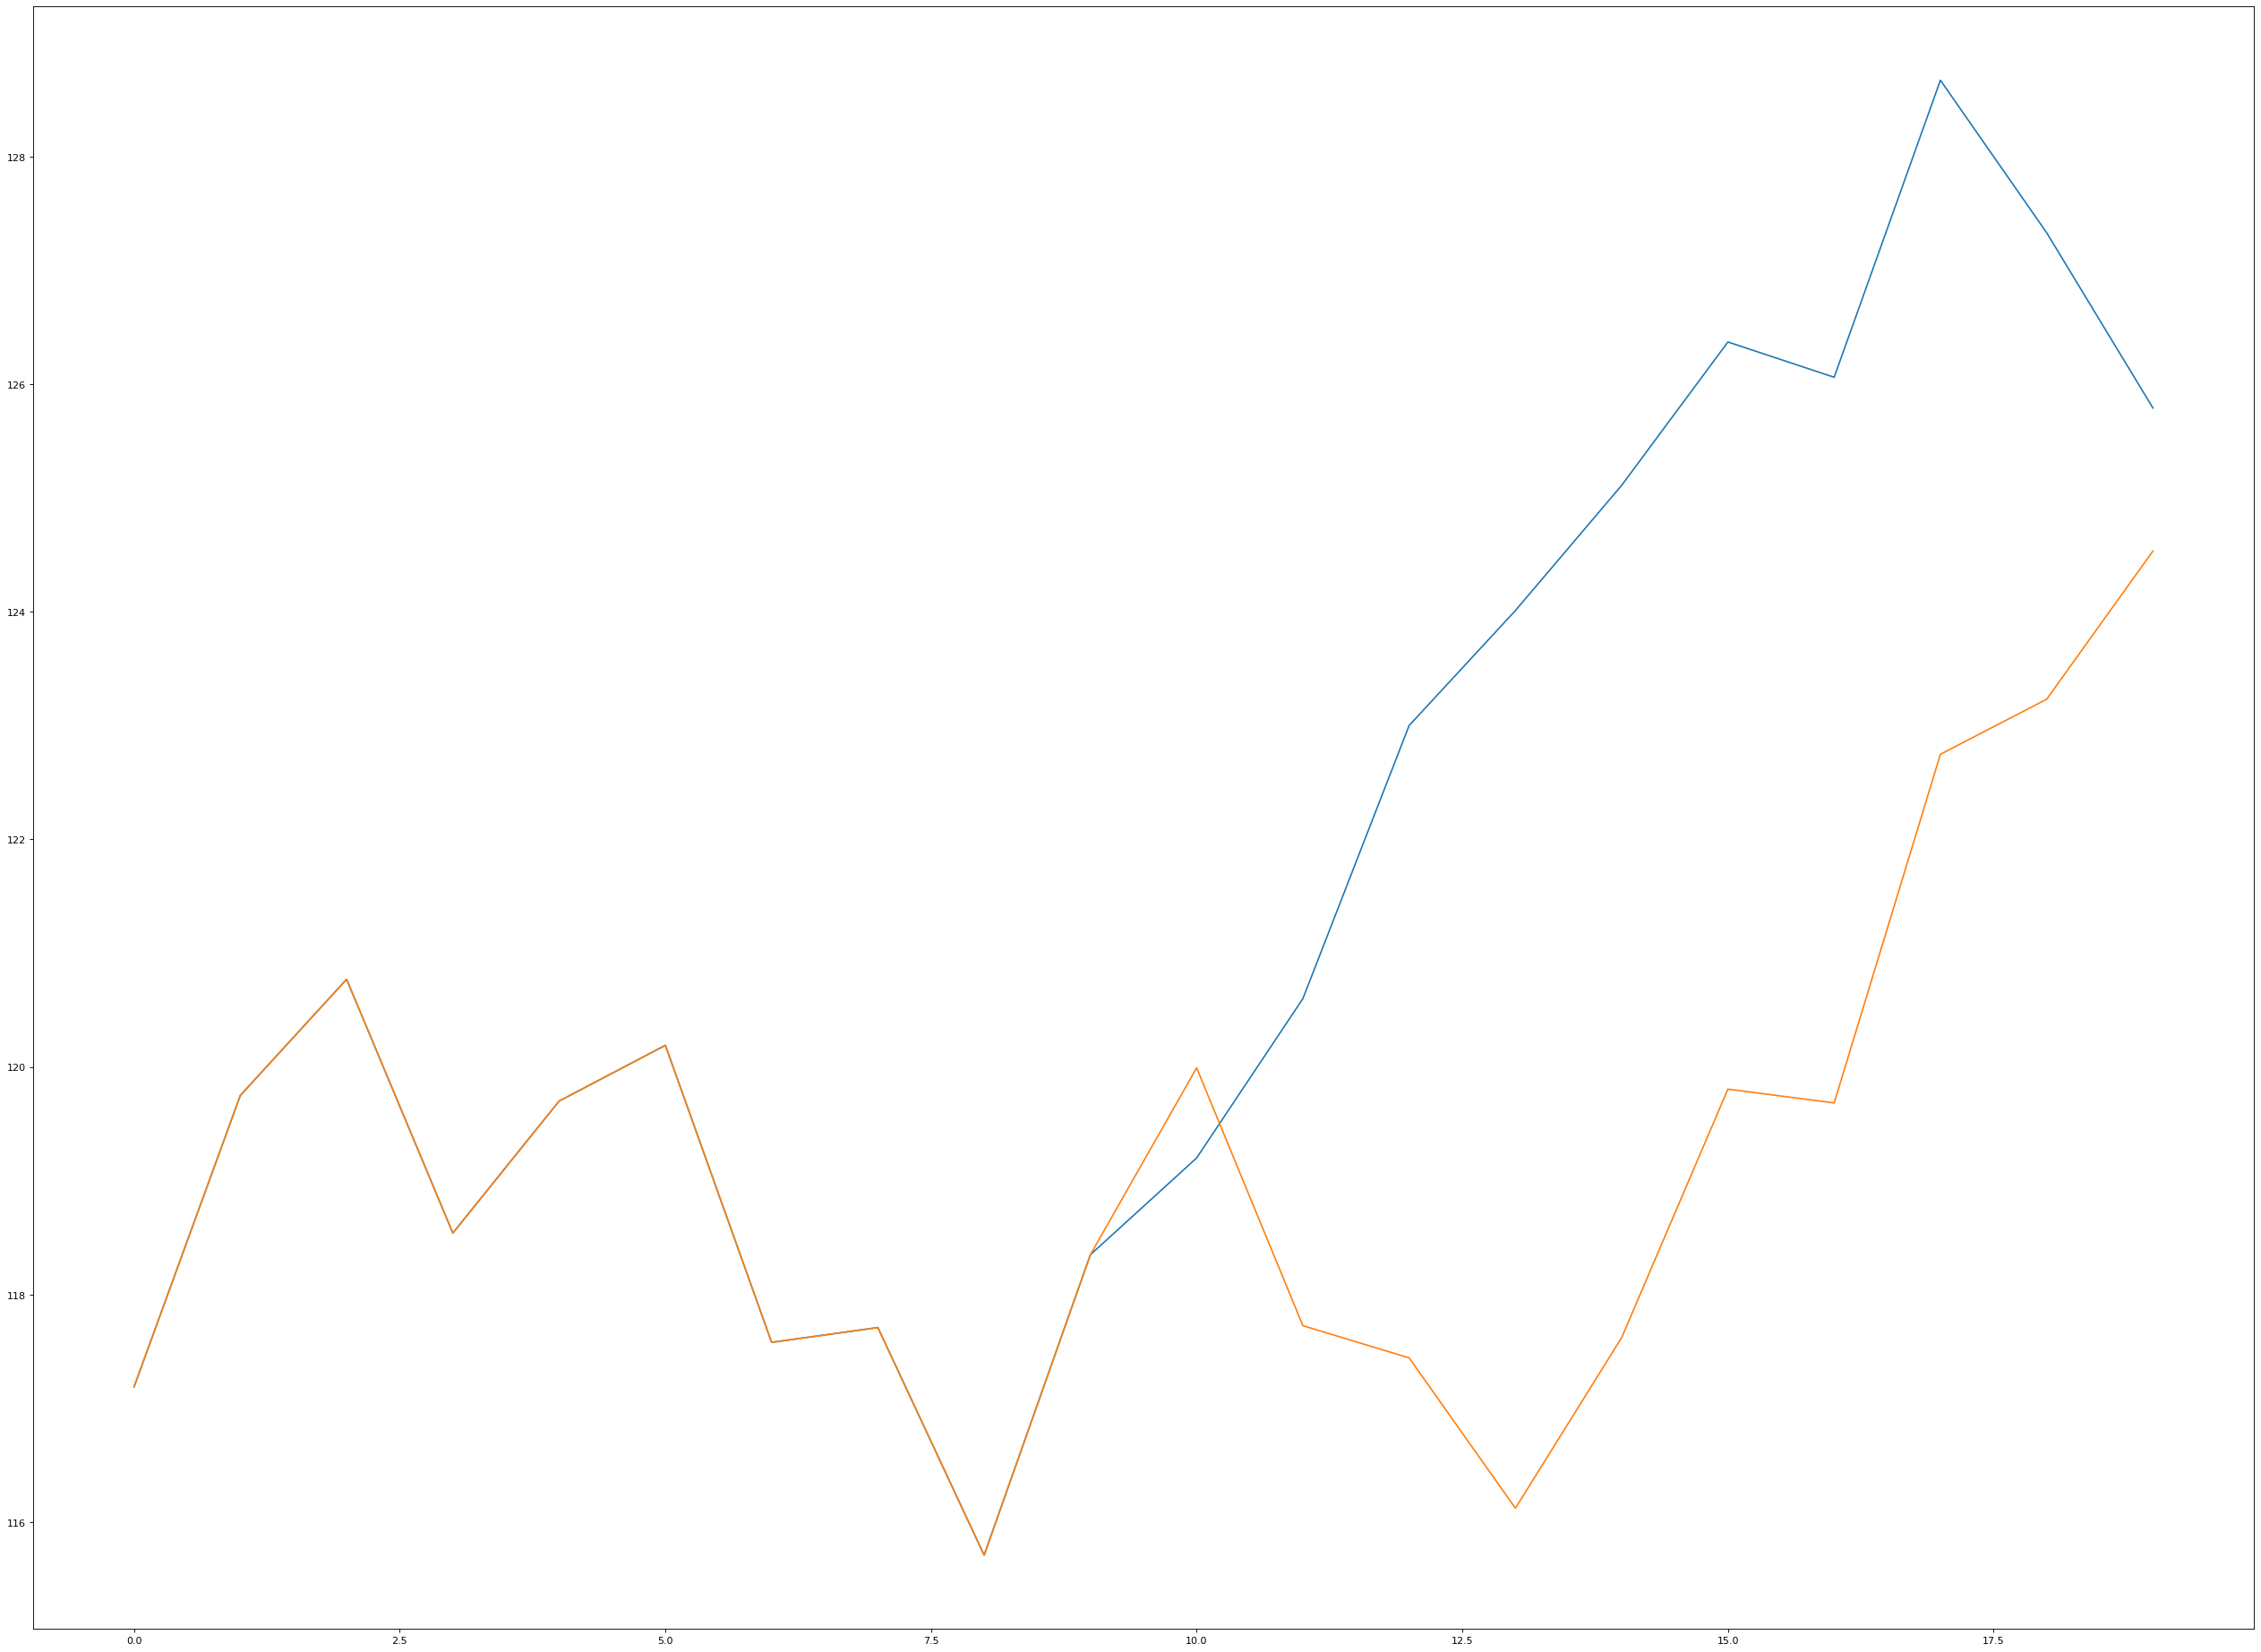

In [36]:
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(20), true_y_test[-20:])
plt.plot(range(20), np.append(true_y_test[-20:-10], predicted_y_test[-10:]))
plt.show()